# Implémentation des formules de mortalité

Objectifs :

- 1) Extraire de la table de mortalité TH00-02_TF00-02.xlsx les colonnes $x$ et $l_x$ sous forme de tableau
- 2) Calculer les probabilités $p_x$, $q_x$, $np_x$, $nq_x$
- 3) Vérifier les formules actuarielles
- 4) Visualiser $p_x$ et $q_x$
- 5) Exemple d'application

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

## 1. Construction du tableau des âges $x$ et des survivants $l_x$

In [3]:
# Lecture du fichier
excel_path = "/Users/soline/Desktop/M2 IMAFA/PFE/PFE_IMAFA_2025_EqTech/TH00-02_TF00-02.xlsx"
df = pd.read_excel(excel_path, sheet_name="TH00-02")

col_age = df.columns[0]
col_lx  = df.columns[1]

# Conversion propre de l'âge
df["age_num"] = pd.to_numeric(df[col_age], errors="coerce")

# Trouver où commence la table (âge = 0)
start = df.loc[df["age_num"] == 0].index[0]

# Garder uniquement la partie utile
df = df.loc[start:, [col_age, col_lx]]

# Nettoyage : conversion en numérique
df["age"] = pd.to_numeric(df[col_age], errors="coerce").astype(int)
df["lx"]  = pd.to_numeric(df[col_lx], errors="coerce")

df = df.dropna()

# Création d'un tableau numpy (âge, l_x)
lx_array = df[["age", "lx"]].to_numpy()

lx_array[:10]   # aperçu

array([[     0, 100000],
       [     1,  99511],
       [     2,  99473],
       [     3,  99446],
       [     4,  99424],
       [     5,  99406],
       [     6,  99390],
       [     7,  99376],
       [     8,  99363],
       [     9,  99350]])

### Visualisons l'évolution du nombre de survivants $l_x$ en fonction de l'âge $x$ :

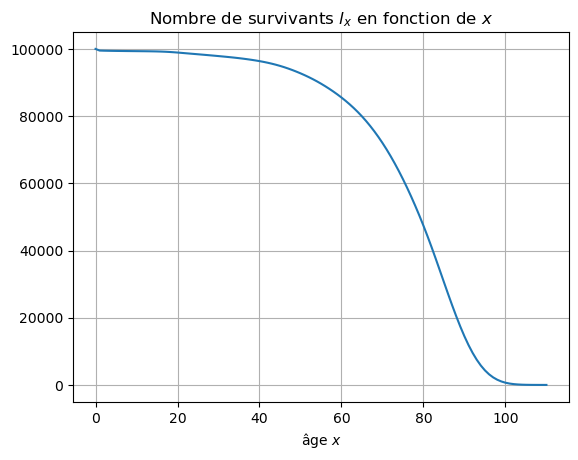

In [4]:
import matplotlib.pyplot as plt

age = lx_array[:, 0]   # colonne 0 = âges
survivants = lx_array[:, 1]  # colonne 1 = l_x

plt.plot(age, survivants)
plt.xlabel('âge $x$')
plt.title('Nombre de survivants $l_x$ en fonction de $x$')
plt.grid(True)
plt.show()

## 3. Implémentation des formules actuarielles

On définit une classe `TableMortalité` basée sur cette vraie table TH00-02.

Rappels :
- $p_x = \dfrac{l_{x+1}}{l_x}$
- $q_x = \dfrac{l_x - l_{x+1}}{l_x}$
- $_np_x = \dfrac{l_{x+n}}{l_x}$
- $_nq_x = \dfrac{l_x - l_{x+n}}{l_x}$
- $_mq_x = {}_mp_x \, q_{x+m}$ (vivre m ans puis mourir l'année suivante)

In [13]:
import numpy as np
from dataclasses import dataclass

@dataclass
class TableMortalité:
    lx: np.ndarray  

    def p(self, x):                                 #p_x = l_{x+1} / l_x
        return self.lx[x+1, 1] / self.lx[x, 1]

    def q(self, x):                                 #q_x = (l_x - l_{x+1}) / l_x
        return (self.lx[x, 1] - self.lx[x+1, 1]) / self.lx[x, 1]

    def n_p(self, x, n):                            #np_x = l_{x+n} / l_x
        return self.lx[x+n, 1] / self.lx[x, 1]

    def n_q(self, x, n):                            #nq_x = (l_x - l_{x+n}) / l_x
        return (self.lx[x, 1] - self.lx[x+n, 1]) / self.lx[x, 1]

    def prod_p(self, x, n):                         #p_x * p_{x+1} * ... * p_{x+n-1}
        res = 1
        for k in range(n):
            res *= self.p(x + k)
        return res

    def m_plus_n_p(self, x, m, n):                  #{m+n}p_x = mp_x * np_{x+m}
        return self.n_p(x, m) * self.n_p(x + m, n)

    def m_q(self, x, m):                            #mp_x * q_{x+m}
        return self.n_p(x, m) * self.q(x + m)

    def m_n_q(self, x, m, n):                       #mp_x * nq_{x+m}
        return self.n_p(x, m) * self.n_q(x + m, n)

    def diff_p(self, x, m):                         #mp_x − {m+1}p_x
        return self.n_p(x, m) - self.n_p(x, m+1)

In [19]:
table = TableMortalité(lx_array)

x = 40
print("p_40 =", table.p(x))
print("q_40 =", table.q(x))
print("10p_40 =", table.n_p(x, 10))
print("10q_40 =", table.n_q(x, 10))

p_40 = 0.9976340939513744
q_40 = 0.0023659060486255954
10p_40 = 0.9623011549357159
10q_40 = 0.037698845064284156


## 4. Vérifications numériques des formules actuarielles

On vérifie maintenant sur la vraie table :
- $p_x + q_x = 1$  
- $_np_x = p_x p_{x+1} \dots p_{x+n-1}$  
- $_{m+n}p_x = {}_mp_x \cdot {}_np_{x+m}$  
- $_mq_x = {}_mp_x \cdot q_{x+m}$  
- $_mp_x - {}_{m+1}p_x = {}_mp_x q_{x+m}$

In [12]:
x = 30
m = 5
n = 10

print("p_x + q_x =", table.p(x) + table.q(x))
print("np_x (direct)   =", table.n_p(x, n))
print("np_x (produit) =", table.prod_p(x, n))
print("{m+n}p_x =", table.n_p(x, m + n))
print("mp_x * np_{x+m} =", table.m_plus_n_p(x, m, n))
print("mq_x =", table.m_q(x, m))
print("mp_x - {m+1}p_x =", table.diff_p(x, m))

p_x + q_x = 1.0
np_x (direct)   = 0.9846633289056912
np_x (produit) = 0.9846633289056913
{m+n}p_x = 0.970184939205068
mp_x * np_{x+m} = 0.970184939205068
mq_x = 0.0015224277102278533
mp_x - {m+1}p_x = 0.0015224277102279249


## 5. Visualisation des probabilités $p_x$ et $q_x$

On trace maintenant les probabilités annuelles de survie et de décès pour la table TH00-02.

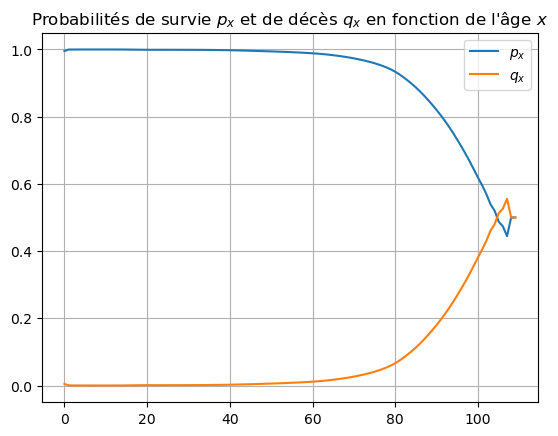

In [16]:
lx = lx_array[:,1]

px = lx[1:] / lx[:-1]
qx = 1 - px

plt.plot(age[:-1], px, label="$p_x$")
plt.plot(age[:-1], qx, label="$q_x$")
plt.title("Probabilités de survie $p_x$ et de décès $q_x$ en fonction de l'âge $x$")
plt.legend()
plt.grid()
plt.show()

## 5. Exemple d'application

Prenons un homme âgé de 30 ans :

- $_{20}p_{30}$ : probabilité de survivre jusqu'à 50 ans.
- $_{20}q_{30}$ : probabilité de décéder avant 50 ans.
- $_5q_{30}$ : probabilité de décéder avant 35 ans.
- $_5p_{30} q_{35}$ : probabilité de décéder entre 35 et 36 ans.

In [18]:
x = 30
print("20p_30 =", table.n_p(x, 20))
print("20q_30 =", table.n_q(x, 20))
print("5q_30  =", table.n_q(x, 5))
print("Vivre 5 ans puis mourir l'année suivante =", table.m_q(x, 5))

20p_30 = 0.9475426586287933
20q_30 = 0.0524573413712067
5q_30  = 0.0063451517318892404
Vivre 5 ans puis mourir l'année suivante = 0.0015224277102278533
